Research Paper: https://doi.org/10.1109/ACCESS.2023.3266275

# Time Series Forecasting and Modeling of Food Demand Supply Chain Based on Regressors 


## ABSTRACT
Accurate demand forecasting has become extremely important, particularly in the food
industry, because many products have a short shelf life, and improper inventory management can result in
significant waste and loss for the company. Several machine learning and deep learning techniques recently
showed substantial improvements when handling time-dependent data. This paper takes the ‘Food Demand
Forecasting’ dataset released by Genpact, compares the effect of various factors on demand, extracts the
characteristic features with possible influence, and proposes a comparative study of seven regressors to
forecast the number of orders. In this study, we used Random Forest Regressor, Gradient Boosting Regressor
(GBR), Light Gradient Boosting Machine Regressor (LightGBM), Extreme Gradient Boosting Regressor
(XGBoost), Cat Boost Regressor, Long Short-Term Memory (LSTM), Bidirectional LSTM (BiLSTM) in
particular. The results demonstrate the potential of deep learning models in forecasting and highlight the
superiority of LSTM over other algorithms. The Root Mean Squared Log Error( RMSLE), Root Mean Square
Error(RMSE),Mean Average Percentage Error( MAPE), and Mean Average Error(MAE) reach 0.28, 18.83,
6.56%, and 14.18, respectively

## AIM
The aim of this notebook is to do my own implementation of this research, and get better results.

## NOVELTY OF MY IMPLEMENTATION

As this is a forecasting problem, calculating lag features and
Exponentially Weighted Moving Average (EWMA) for lag
values play a vital role in improving prediction accuracy.

What did I do differently? I created only one lag feature,
which is the 10 weeks lag of num_orders (target variable).

I created a few more features than the research paper.
Another thing I did was to use label encoder for all the
categoric features, but I deleted the 'id' column as it is unique
for every entry. I also carefully selected my categoric features
to ensure better performance.

In my implementation of the present article,
I achieved better performance in the first 5 models: Random Forest Regressor,
GBR, LightGBM, XGBoost, Cat Boost Regressor, although  Random Forest Regressor
is overfitting. As for the last two models: LSTM and Bi-LSTM, I am yet to
conclude training them due to time constraints, but it is in progress still.
The LSTM model is training on 300epocs so it will take some time to run.

The performance of my best model: Cat Boost Regressor (RMSLE = 0.0084) outperforms the
best model in the research paper: LSTM (RMSLE = 0.28) even without tuning hyperparemeters.
Making my approach a much more superior one. Period!


changes: try binary encoding

In [1]:
!pip install catboost
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from scipy import stats

import matplotlib.dates as mdates
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, ReLU, Bidirectional
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Mounting Google Drive
from google.colab import drive  # Import for accessing Google Drive

# Unzipping files
import zipfile  # Import for extracting zip files

# Data Loading

In [4]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/datasets/Forecasting_of_Food_Demand.zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Extract the CSV files
    train_path = zip_ref.extract('train.csv', '/content/')
    test_path = zip_ref.extract('test.csv', '/content/')
    sub_path = zip_ref.extract('sample_submission.csv', '/content/')
    meals_path = zip_ref.extract('meal_info.csv', '/content/')
    centres_path = zip_ref.extract('fulfilment_center_info.csv', '/content/')

# Read the CSV files
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sub = pd.read_csv(sub_path)
meals = pd.read_csv(meals_path)
centres = pd.read_csv(centres_path)

Mounted at /content/drive


# Exploratory Data Analysis: EDA
# Dataset overview

In [5]:
test.head(1)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0


In [6]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [8]:
train.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


In [4]:
meals.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [5]:
centres.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


# Data Preparation and Processing

## Univariate Analysis

**Does our dataset have outliers?**

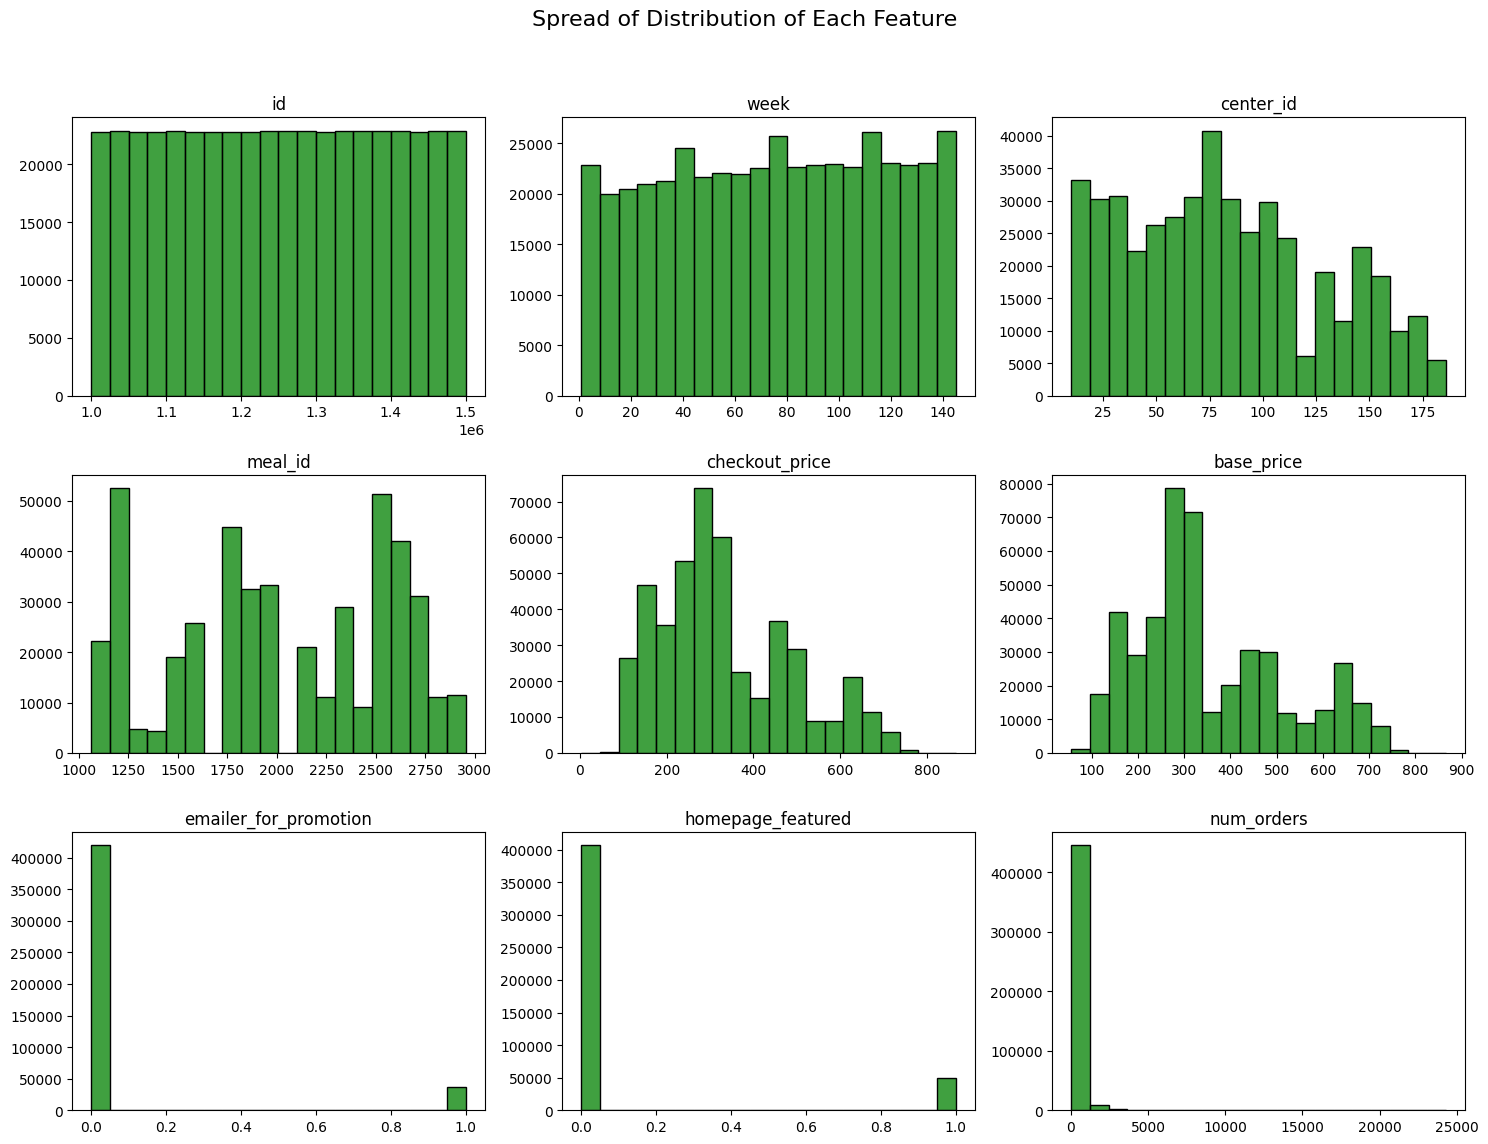

In [9]:
# Generating plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Adjust number of rows and columns as needed
fig.suptitle('Spread of Distribution of Each Feature', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(train.columns):
    if i < len(axes):  # Ensure we don't try to plot more columns than we have axes for
        sns.histplot(train[column], bins=20, kde=False, ax=axes[i], color='green')
        axes[i].set_title(column)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save and show plot
plt.show()

As observed for ‘‘num_orders’’ above,
most of the values for this feature are concentrated around
0-1000, but the spread of the distribution is greater than
20000 which implies that there might be a possibility of an outlier.

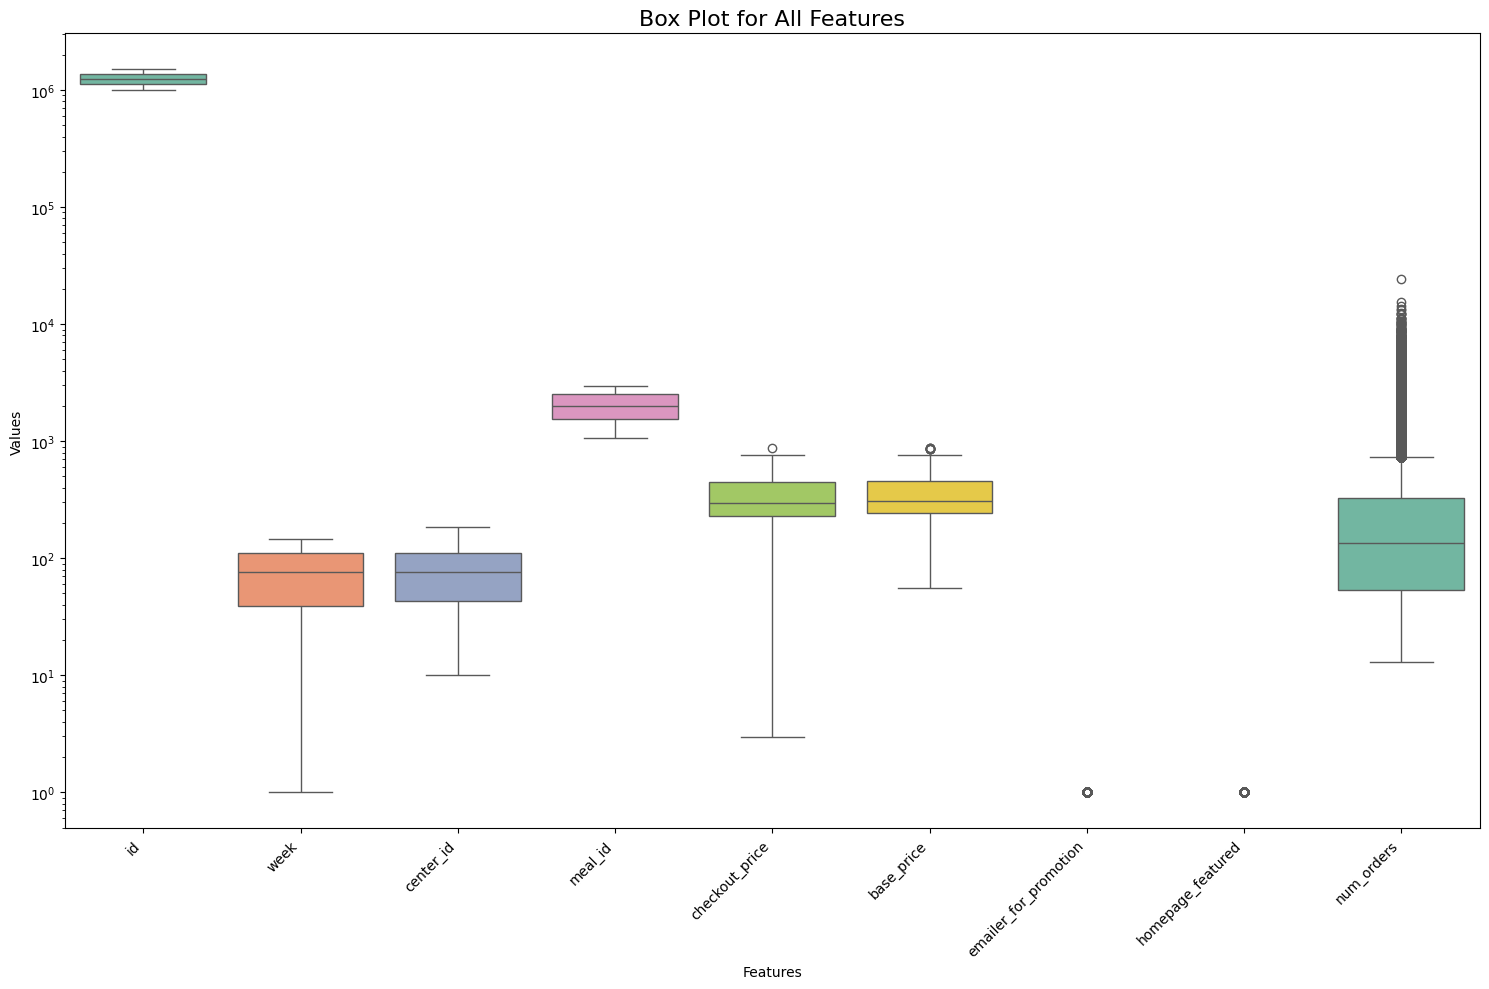

In [10]:
# Creating a boxplot with logarithmic scale for the y-axis
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=train, palette="Set2")

# Set plot title and labels
plt.title('Box Plot for All Features', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Values')

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save and show plot
plt.show()

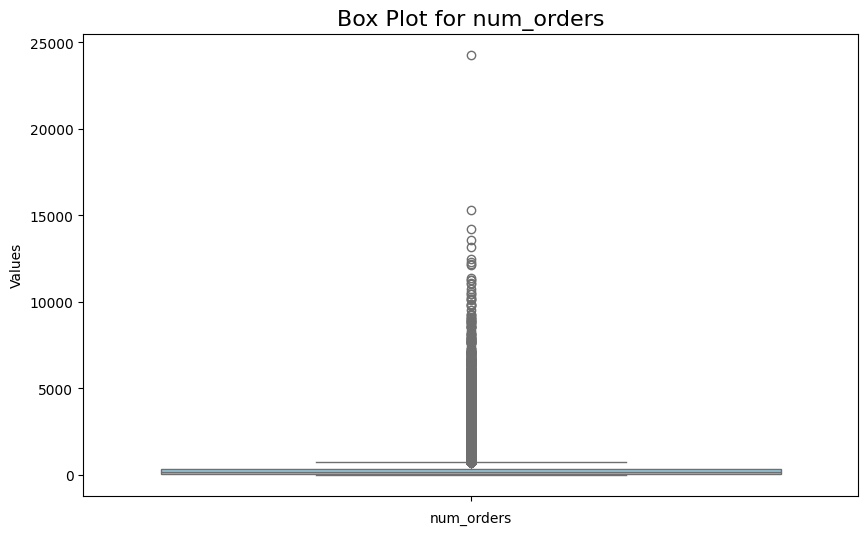

In [11]:
# Creating a boxplot for the 'num_orders' column
plt.figure(figsize=(10, 6))
sns.boxplot(y=train['num_orders'], color='skyblue')

# Set plot title and labels
plt.title('Box Plot for num_orders', fontsize=16)
plt.xlabel('num_orders')
plt.ylabel('Values')

# Show plot
plt.show()

As seen in above, there is only one outlier
in the number of orders that may be a result of miswriting and is therefore removed as it may hinder the further
analysis.

In [12]:
# Count the number of rows with num_orders > 20,000
num_rows_to_delete = train[train['num_orders'] > 20000].shape[0]
print(f"Number of rows with num_orders > 20,000: {num_rows_to_delete}")

# Delete rows with num_orders > 20,000
train = train[train['num_orders'] <= 20000]

Number of rows with num_orders > 20,000: 1


In [13]:
centres.head(1)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7


**Which type of center received the most orders?**

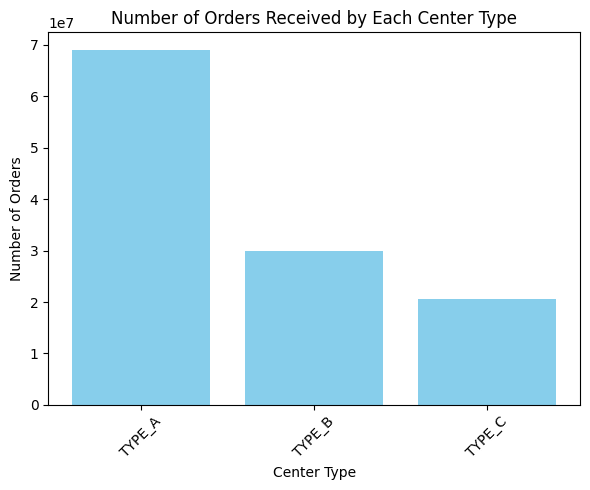

In [14]:
# Let's merge the 'train' DataFrame with the 'centers' DataFrame to get center type information
train_with_center_type = pd.merge(train, centres, on='center_id', how='left')

# Now, let's calculate the total number of orders received by each center type
orders_by_center_type = train_with_center_type.groupby('center_type')['num_orders'].sum().reset_index()

# Plotting
plt.figure(figsize=(6, 5))
plt.bar(orders_by_center_type['center_type'], orders_by_center_type['num_orders'], color='skyblue')
plt.title('Number of Orders Received by Each Center Type')
plt.xlabel('Center Type')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Type_A centers received the highest number of
orders, whereas Type_C centers received the least.

**What are the top 5 centers?**

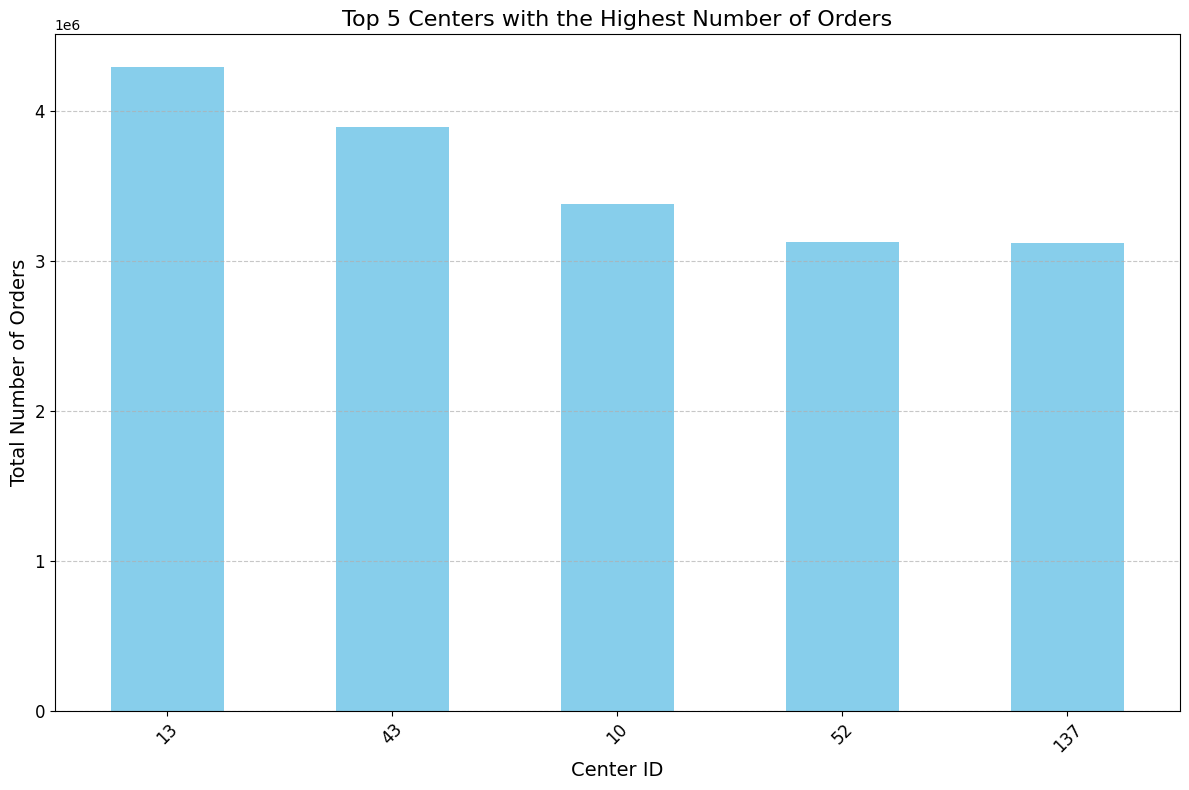

In [15]:
# Assuming train is your DataFrame containing the data
top_centers = train.groupby('center_id')['num_orders'].sum().nlargest(5)

# Plotting
plt.figure(figsize=(12, 8))
top_centers.plot(kind='bar', color='skyblue')
plt.title('Top 5 Centers with the Highest Number of Orders', fontsize=16)
plt.xlabel('Center ID', fontsize=14)
plt.ylabel('Total Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
# Get the top 5 center IDs
top_center_ids = top_centers.index

# Merge with the centers DataFrame to get center type
top_centers_info = centres[centres['center_id'].isin(top_center_ids)]

# Display center type of the top 5 centers
top_centers_with_type = top_centers_info.merge(top_centers.rename('num_orders'), left_on='center_id', right_index=True)
top_centers_with_type = top_centers_with_type[['center_id', 'center_type']].drop_duplicates()

print(top_centers_with_type)


    center_id center_type
1          13      TYPE_B
36         43      TYPE_A
56         10      TYPE_B
58         52      TYPE_B
62        137      TYPE_A


Type_A has the highest number of
orders, but, according to the above, it is seen that center 13 of
Type_B has the highest number of orders. The reason behind
it is that center Type_A has the most centers as shown below

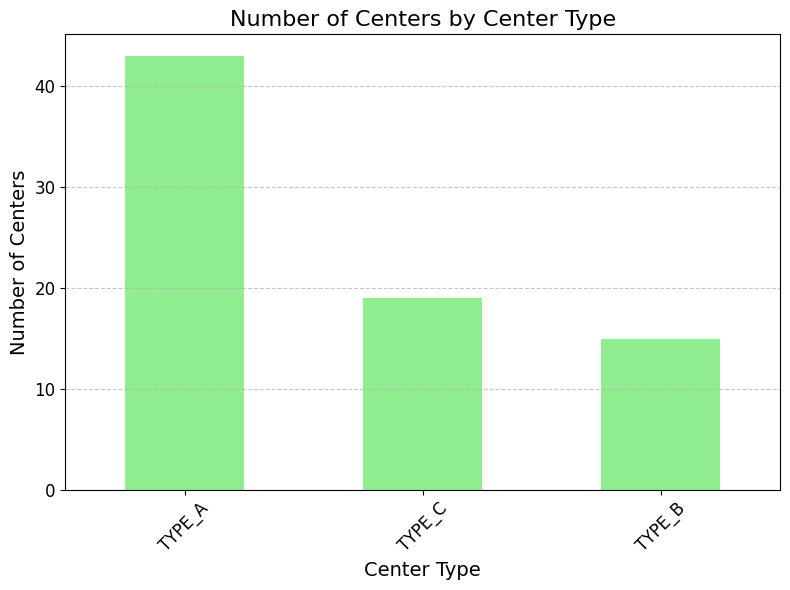

In [17]:
# Count the number of centers under each center type
center_type_counts = centres['center_type'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
center_type_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Centers by Center Type', fontsize=16)
plt.xlabel('Center Type', fontsize=14)
plt.ylabel('Number of Centers', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**What region has the highest number of orders?**

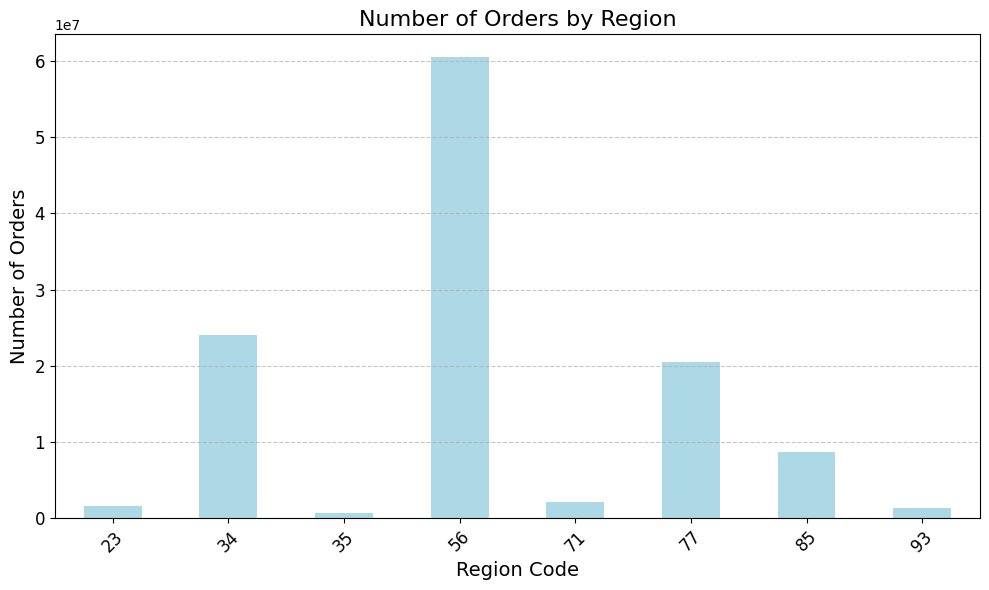

In [18]:
# Merge the train DataFrame with the centres DataFrame
merged_data = train.merge(centres, on='center_id')

# Group by region_code and sum up the number of orders for each region
region_order_counts = merged_data.groupby('region_code')['num_orders'].sum()

# Plotting
plt.figure(figsize=(10, 6))
region_order_counts.plot(kind='bar', color='lightblue')
plt.title('Number of Orders by Region', fontsize=16)
plt.xlabel('Region Code', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 Region 56 received an astonishingly high number of
orders when compared to other regions

In [19]:
meals.head(1)

,meal_id,category,cuisine
0,1885,Beverages,Thai


**Which category of meals have the highest demand?**

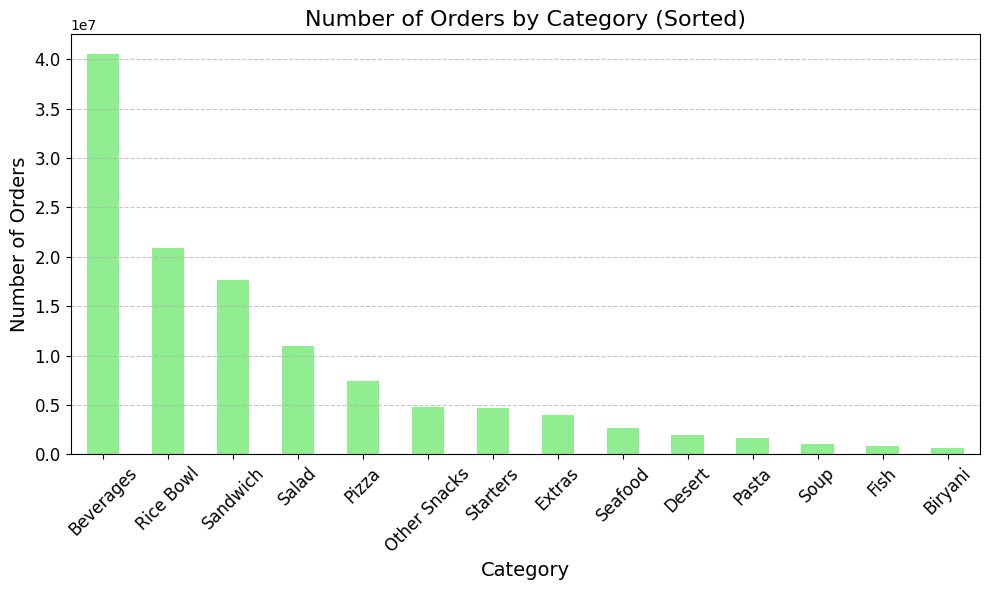

In [20]:
# Merge the train DataFrame with the meals DataFrame on meal_id
merged_data = train.merge(meals, on='meal_id')

# Group by category and sum up the number of orders for each category
category_order_counts = merged_data.groupby('category')['num_orders'].sum()

# Sort the categories by the total number of orders in descending order
category_order_counts_sorted = category_order_counts.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
category_order_counts_sorted.plot(kind='bar', color='lightgreen')
plt.title('Number of Orders by Category (Sorted)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Beverages are the food category with the highest number of orders (highest demand), and Biryani is the food category with the least number of orders (lowest demand).

**Which meal was ordered the most?**

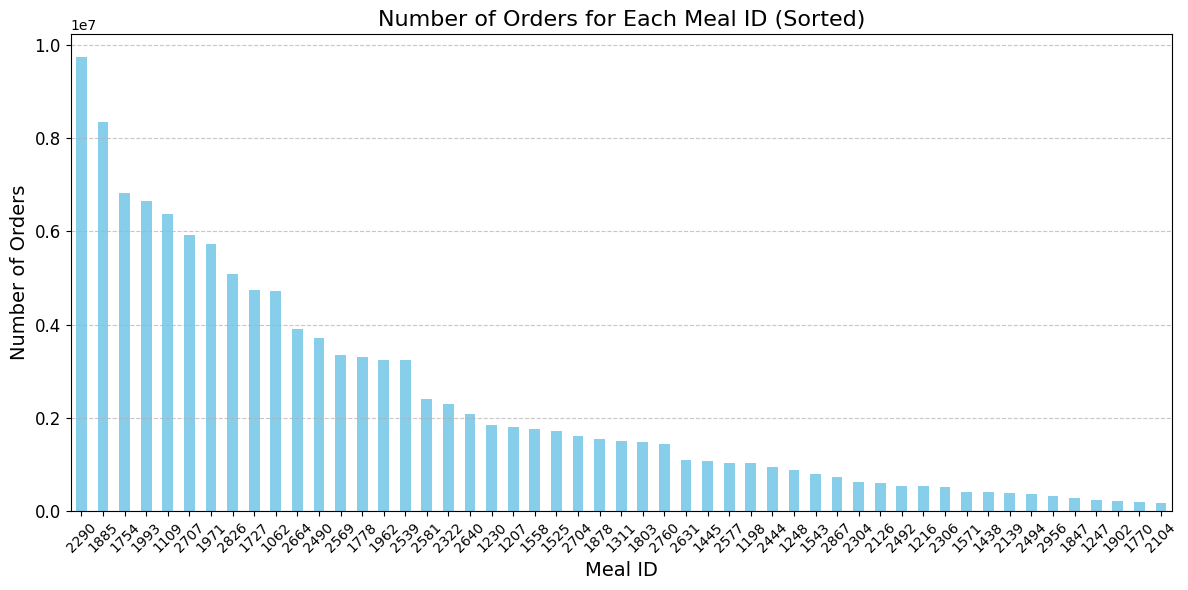

In [21]:
# Group by meal_id and sum up the number of orders for each meal
meal_order_counts = train.groupby('meal_id')['num_orders'].sum()

# Sort the meal IDs by the total number of orders in descending order
meal_order_counts_sorted = meal_order_counts.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
meal_order_counts_sorted.plot(kind='bar', color='skyblue')
plt.title('Number of Orders for Each Meal ID (Sorted)', fontsize=16)
plt.xlabel('Meal ID', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Meal ID 2290 has received the most orders, as shown in above. The number of orders for various meal IDs does not differ significantly in many cases.

**What are the top 5 cities by demand? (number of orders)**

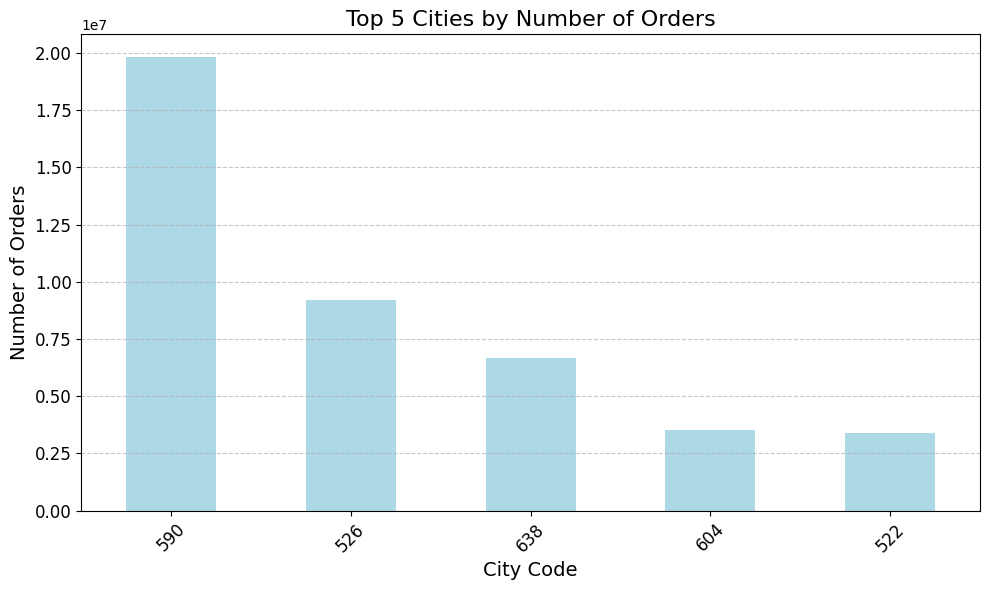

In [22]:
# Merge the train DataFrame with the centres DataFrame on center_id
merged_data = train.merge(centres, on='center_id')

# Group by city_code and sum up the number of orders for each city
city_order_counts = merged_data.groupby('city_code')['num_orders'].sum()

# Select the top 5 cities with the highest number of orders
top_5_cities = city_order_counts.nlargest(5)

# Plotting
plt.figure(figsize=(10, 6))
top_5_cities.plot(kind='bar', color='lightblue')
plt.title('Top 5 Cities by Number of Orders', fontsize=16)
plt.xlabel('City Code', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

City - 590 has the most orders with 18.5M, which is nearly 10M more than the city with the second-highest number of orders, City 526, with 8.6M.

**Which week did we have the lowest demand?**

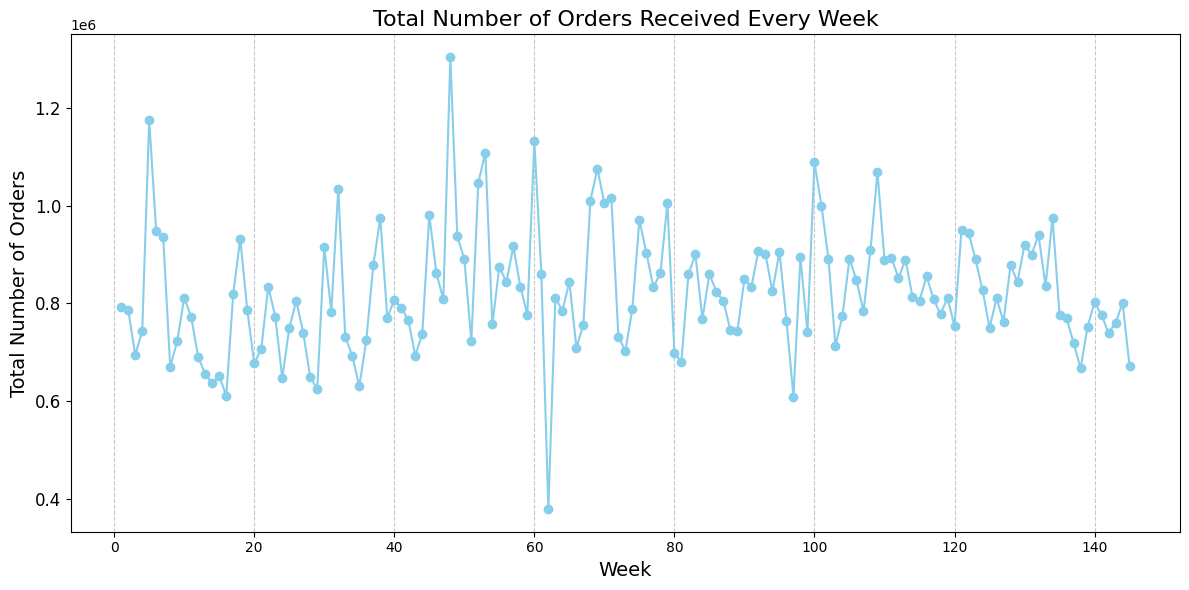

In [23]:
# Group by week and sum up the number of orders for each week
weekly_order_counts = train.groupby('week')['num_orders'].sum()

# Plotting
plt.figure(figsize=(12, 6))
weekly_order_counts.plot(kind='line', marker='o', color='skyblue')
plt.title('Total Number of Orders Received Every Week', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Number of Orders', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The highest number of orders were received in week 48 and the lowest number of orders in week 62.

## Multivariate Analysis

**Is there multicollinearity in our variables?**

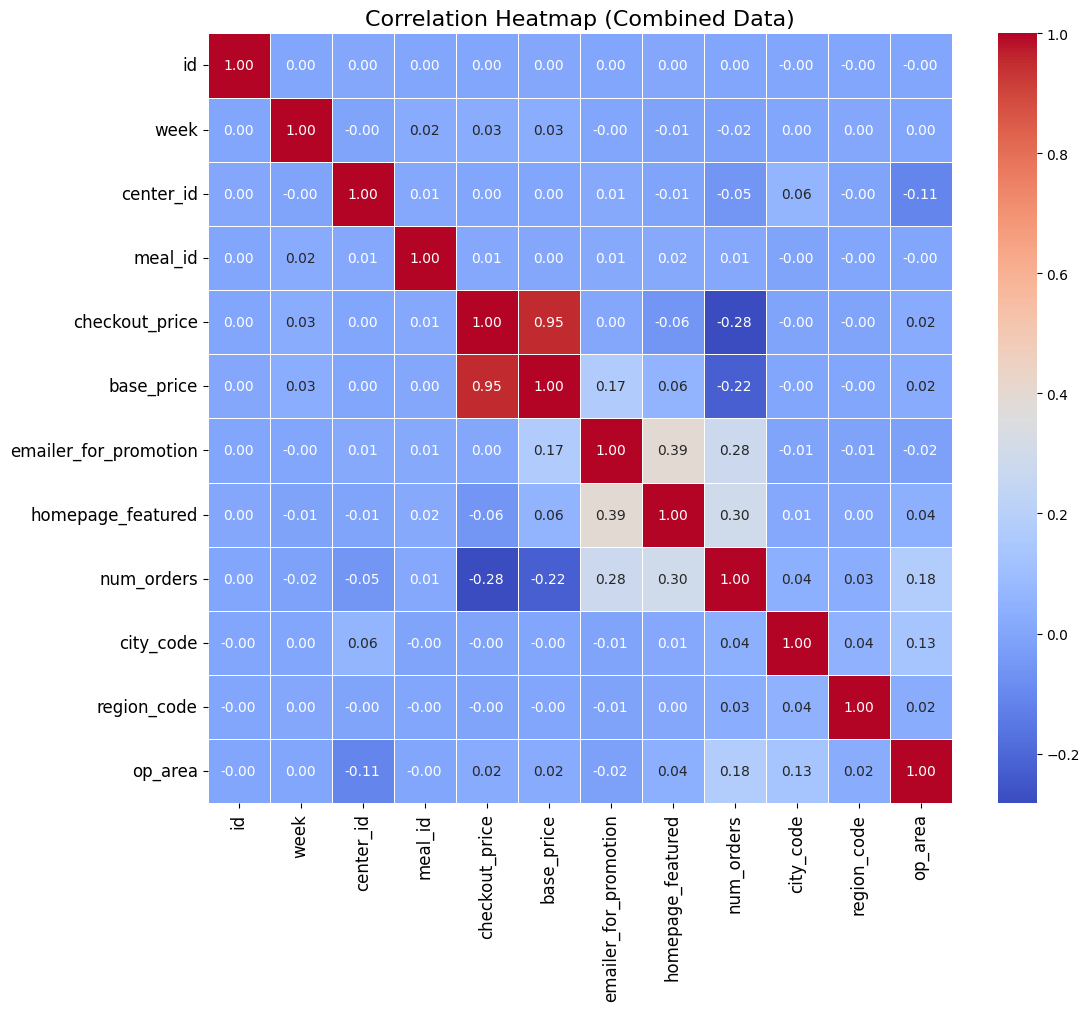

In [24]:
# Select numeric columns from train, centres, and meals DataFrames
train_numeric = train.select_dtypes(include=['float64', 'int64'])
centres_numeric = centres.select_dtypes(include=['float64', 'int64'])
meals_numeric = meals.select_dtypes(include=['float64', 'int64'])

# Merge train, centres, and meals DataFrames
merged_data = pd.merge(train_numeric, centres_numeric, on='center_id')
merged_data = pd.merge(merged_data, meals_numeric, on='meal_id')

# Calculate the correlation matrix
corr_matrix = merged_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Combined Data)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Base price and checkout price have a high correlation. So let's visualize it with a scatter plot.

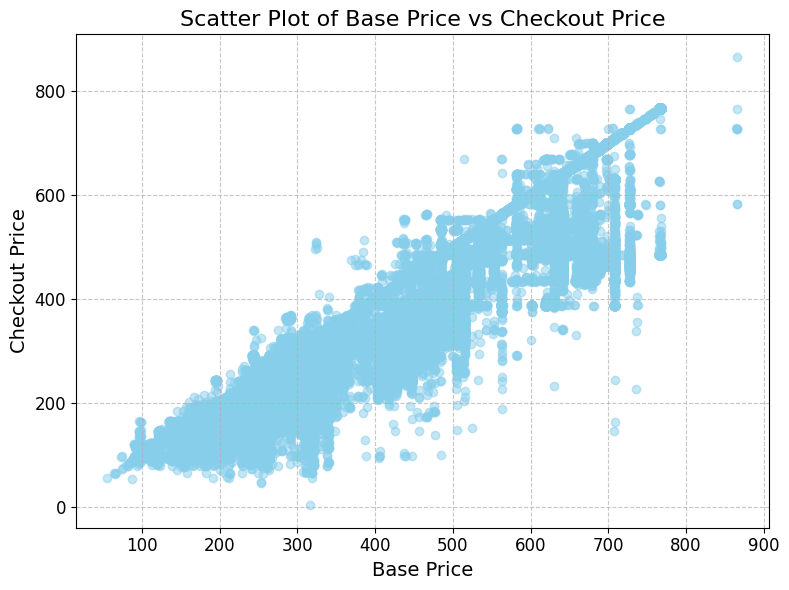

In [25]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(train['base_price'], train['checkout_price'], color='skyblue', alpha=0.5)
plt.title('Scatter Plot of Base Price vs Checkout Price', fontsize=16)
plt.xlabel('Base Price', fontsize=14)
plt.ylabel('Checkout Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The figures above prove that base_price and checkout_price have a high correlation, so one variable, checkout_price must be removed.

## Feature Engineering

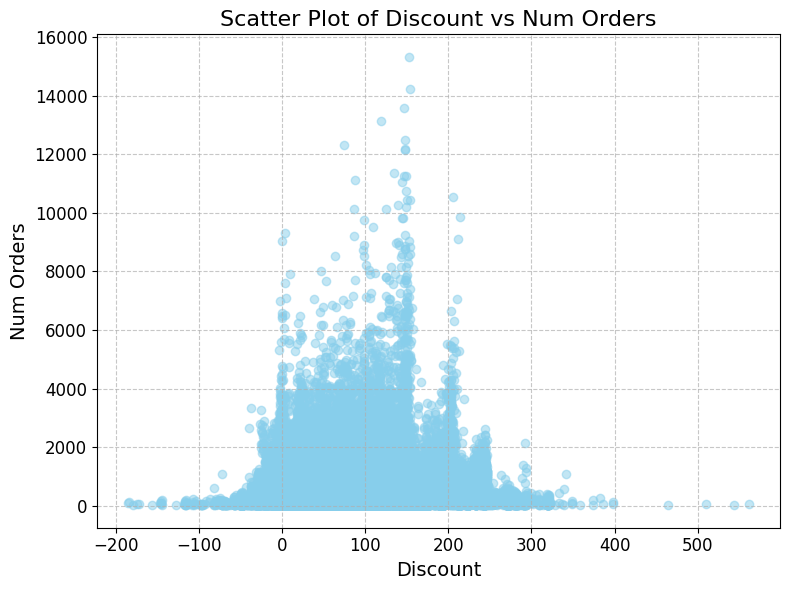

In [26]:
# Create the 'discount' feature
train['discount'] = train['base_price'] - train['checkout_price']

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(train['discount'], train['num_orders'], color='skyblue', alpha=0.5)
plt.title('Scatter Plot of Discount vs Num Orders', fontsize=16)
plt.xlabel('Discount', fontsize=14)
plt.ylabel('Num Orders', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 a new feature is
created: a discount, which is the difference between the base
price and the checkout price. We attempted to determine
whether or not there is a relationship between the discount
and the number of orders. Surprisingly, there is no strong link
between them

In [27]:
# Drop the 'checkout_price' column permanently
train.drop('checkout_price', axis=1, inplace=True)

1. **Lag Characteristics**: Imagine you're trying to predict something (like sales) for next week. One way to do this is by looking at what happened in previous weeks. Lag characteristics are like looking back in time to see what happened in the past, which can help us predict what might happen in the future.

2. **Exponentially Weighted Moving Average (EWMA)**: When we use lag characteristics, we often give equal importance to data from all the previous weeks. However, in real life, we usually care more about recent data because it's more relevant to what's happening now. EWMA is a way to consider recent data more than older data when making predictions.

EWMA(w) = α ∗ x(w) + (1 − α) ∗ EWMA(w − 1)

3. **How EWMA Works**: EWMA calculates a kind of average where recent data gets more weight than older data. The formula for EWMA looks complicated, but it's not too hard to understand. Basically, it says that the EWMA for this week is a combination of the actual data for this week and the EWMA from last week. The parameter α decides how much weight we give to the actual data for this week. Setting α to 0.5 means we give equal importance to the actual data for this week and the EWMA from last week.

In simpler terms, EWMA helps us make better predictions by focusing more on recent data, which is often more important for understanding what might happen next.

In this case, data from the previous 10 weeks is used to forecast demand for the next 10 weeks.

In [28]:
# # Create lag features
# train['base_price_lag_10'] = train['base_price'].shift(10)
# train['discount_lag_10'] = train['discount'].shift(10)

# # Drop rows with NaN values resulting from shifting
# # train.dropna(inplace=True)

In [29]:
train.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
discount                 0
dtype: int64

In [30]:
# Calculate the EWMA using the pandas rolling function with alpha = 0.5
train['ewma_base_price'] = train['base_price'].ewm(alpha=0.5, min_periods=10).mean()
train['ewma_discount'] = train['discount'].ewm(alpha=0.5, min_periods=10).mean()

# Display the DataFrame with the EWMA column added
print(train[['week', 'base_price', 'discount', 'ewma_base_price', 'ewma_discount']].head(20))

    week  base_price  discount  ewma_base_price  ewma_discount
0      1      152.29     15.46              NaN            NaN
1      1      135.83     -1.00              NaN            NaN
2      1      135.86      1.00              NaN            NaN
3      1      437.53     98.03              NaN            NaN
4      1      242.50     -1.00              NaN            NaN
5      1      252.23      1.00              NaN            NaN
6      1      184.36      1.00              NaN            NaN
7      1      183.36      1.00              NaN            NaN
8      1      192.06     -1.00              NaN            NaN
9      1      384.18     58.26       290.865718      29.895230
10     1      390.00     66.99       340.457074      48.451676
11     1      388.00     65.93       364.234342      57.192972
12     1      310.43     -1.00       337.328887      28.092934
13     1      446.23      1.00       391.782767      14.545640
14     1      297.79     32.95       344.784949      23

In [31]:
train.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
discount                 0
ewma_base_price          9
ewma_discount            9
dtype: int64

It seems that after calculating the exponentially weighted moving averages (EWMA) for the 'base_price' and 'discount' columns, the resulting new columns ('ewma_base_price' and 'ewma_discount') have 9 NaN values each. This is likely due to the min_periods parameter set to 10 in the ewm() function.

let's handle these missing values by interpolation

In [32]:
# Interpolate NaN values using backward linear interpolation
train['ewma_base_price'] = train['ewma_base_price'].interpolate(method='linear', limit_direction='backward')
train['ewma_discount'] = train['ewma_discount'].interpolate(method='linear', limit_direction='backward')

In [33]:
merged_data = pd.merge(train, centres, on='center_id')
merged_data = pd.merge(merged_data, meals, on='meal_id')

In [34]:
merged_data.head()

,id,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,ewma_base_price,ewma_discount,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,152.29,0,0,177,15.46,290.865718,29.895230,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,152.29,0,0,323,16.46,311.990559,9.229357,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,133.92,0,0,96,1.00,294.443949,1.788426,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,134.86,0,0,163,-1.00,303.712718,0.123635,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,147.50,0,0,215,1.00,309.779144,1.055744,647,56,TYPE_C,2.0,Beverages,Thai


Other features calculated include the rank of a meal based
on its base price, meal count features in relation to a meal’s
category, cuisine, center, city, and region, as well as the
highest, lowest, and average prices of the meal in a city and
a region.

In [35]:
def create_featutes(df):
  # Rank of a meal based on its base price
  df['meal_base_price_rank'] = df['base_price'].rank(ascending=False)

  # Meal count features
  meal_count_features = ['category', 'cuisine', 'center_id', 'city_code', 'region_code']
  for feature in meal_count_features:
      df[f'meal_count_{feature}'] = df.groupby(feature)['meal_id'].transform('count')

  # Highest, lowest, and average prices of the meal in a city and a region
  price_features = ['city_code', 'region_code']
  for feature in price_features:
      df[f'{feature}_highest_price'] = df.groupby(feature)['base_price'].transform('max')
      df[f'{feature}_lowest_price'] = df.groupby(feature)['base_price'].transform('min')
      df[f'{feature}_avg_price'] = df.groupby(feature)['base_price'].transform('mean')
  return df

train = create_featutes(merged_data)

# Set to display max columns
pd.set_option('display.max_columns', None)
# Display the DataFrame with the new features added
train.head()

,id,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,ewma_base_price,ewma_discount,city_code,region_code,center_type,op_area,category,cuisine,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,meal_count_region_code,city_code_highest_price,city_code_lowest_price,city_code_avg_price,region_code_highest_price,region_code_lowest_price,region_code_avg_price
0,1379560,1,55,1885,152.29,0,0,177,15.46,290.865718,29.895230,647,56,TYPE_C,2.0,Beverages,Thai,419380.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095
1,1018704,2,55,1885,152.29,0,0,323,16.46,311.990559,9.229357,647,56,TYPE_C,2.0,Beverages,Thai,419380.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095
2,1196273,3,55,1885,133.92,0,0,96,1.00,294.443949,1.788426,647,56,TYPE_C,2.0,Beverages,Thai,438640.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095
3,1116527,4,55,1885,134.86,0,0,163,-1.00,303.712718,0.123635,647,56,TYPE_C,2.0,Beverages,Thai,438416.0,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095
4,1343872,5,55,1885,147.50,0,0,215,1.00,309.779144,1.055744,647,56,TYPE_C,2.0,Beverages,Thai,427081.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095


compute a few more features from the existing ones in train,
which are mentioned as follows:
1) base_price_max: maximum base price for a particular
meal, irrespective of the week, center, city, or region.
2) base_price_mean: the average base price for a particular meal, irrespective of the week, center, city or region.
3) base_price_min: the minimum base price for a particular meal, irrespective of the week, center, city or region.
4) center_cat_count: a count of orders belonging to a
particular category in a particular center.
5) center_cat_price_rank: rank of the price of a particular
category of meals in a particular center.
6) center_cat_week_count: a count of orders belonging to
a particular category in a particular center in a week.
7) center_cui_count: a count of orders belonging to a
particular cuisine in a particular center.
8) center_price_rank: rank of the price of a particular meal
in a particular center.
9) center_week_count: a count of orders in a particular
center in the given week.
10) center_week_price_rank: rank of price of a particular
meal in a particular center in a particular week.
11) city_meal_week_count: a total count of a certain meal
sold in a city in a particular week.
12) meal_count: a count of a certain meal sold in all the
weeks across all centers and regions.
13) meal_city_price_rank: rank of price of a particular
meal in a particular city.
14) meal_price_max: maximum checkout price of the meal
irrespective of the week,center,city or region.
15) meal_price_mean: average checkout price of the meal
irrespective of the week,center,city or region.
16) meal_price_min: minimum checkout price of the meal
irrespective of the week,center,city or
region.
17) meal_price_rank: rank of price of a particular meal.
18) meal_region_price_rank: rank of price of a particular
meal in a particular region.
19) meal_week_count: a total count of a certain meal sold
in the given week.
20) meal_week_price_rank: rank of price of a particular
meal in a particular week.
21) region_meal_count: a region’s total sales of a particular
meal.
22) region_meal_week_count: the total number of a
specific meal sold in a region during a specific
week.
23) type_meal_week_count: the total amount of a specific
meal sold in a center over the course of a particular
week

In [36]:
train.head()

,id,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,ewma_base_price,ewma_discount,city_code,region_code,center_type,op_area,category,cuisine,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,meal_count_region_code,city_code_highest_price,city_code_lowest_price,city_code_avg_price,region_code_highest_price,region_code_lowest_price,region_code_avg_price
0,1379560,1,55,1885,152.29,0,0,177,15.46,290.865718,29.895230,647,56,TYPE_C,2.0,Beverages,Thai,419380.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095
1,1018704,2,55,1885,152.29,0,0,323,16.46,311.990559,9.229357,647,56,TYPE_C,2.0,Beverages,Thai,419380.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095
2,1196273,3,55,1885,133.92,0,0,96,1.00,294.443949,1.788426,647,56,TYPE_C,2.0,Beverages,Thai,438640.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095
3,1116527,4,55,1885,134.86,0,0,163,-1.00,303.712718,0.123635,647,56,TYPE_C,2.0,Beverages,Thai,438416.0,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095
4,1343872,5,55,1885,147.50,0,0,215,1.00,309.779144,1.055744,647,56,TYPE_C,2.0,Beverages,Thai,427081.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095


In real life, or in a business scenario, since we are trying to predict the number of orders, we would not have access to this information. Therefore, any feature based on the number of orders must be excluded, as we cannot extract these features from our test set. The same goes for the EWMA features created above. In the research paper, the EWMA was created based on the number of orders, not the discount and base price like I did.

The author of this research created these features from the training set (which contains the number of orders) and then split it into test and train sets (with the test set being the last 10 weeks). Naturally, any feature created from the target variable (number of orders) will have a high correlation with the target and a high feature importance. However, as I mentioned, this is not possible in real life since the target is what we are trying to predict and will, therefore, be unavailable for preparing the test set.

The features created from the target variable were the only things that gave the models in the research paper such high performance. Initially, based on the RMSLE values, the best score I got was 0.0084 from the CatBoost Regressor, which was better than the 0.28 score from the LSTM model in the research paper (RMSLE scores are better when closer to zero).

As I expected, once I excluded the features created from the number of orders column, the performance dropped significantly to an RMSLE score of 0.54, as we will see in our results later on.

In [37]:
def create_more_features(df):
  # Compute base_price_max, base_price_mean, and base_price_min
  df['base_price_max'] = df['base_price'].groupby(df['meal_id']).transform('max')
  df['base_price_mean'] = df['base_price'].groupby(df['meal_id']).transform('mean')
  df['base_price_min'] = df['base_price'].groupby(df['meal_id']).transform('min')

  # Compute center_cat_count
  # df['center_cat_count'] = df.groupby(['center_id', 'category'])['num_orders'].transform('count')

  # Compute center_cat_price_rank
  df['center_cat_price_rank'] = df.groupby(['center_id', 'category'])['base_price'].transform('rank')

  # Compute center_cat_week_count
  # df['center_cat_week_count'] = df.groupby(['center_id', 'category', 'week'])['num_orders'].transform('sum')

  # Compute center_cui_count
  # df['center_cui_count'] = df.groupby(['center_id', 'cuisine'])['num_orders'].transform('count')

  # Compute center_price_rank
  df['center_price_rank'] = df.groupby(['center_id'])['base_price'].transform('rank')

  # Compute center_week_count
  # df['center_week_count'] = df.groupby(['center_id', 'week'])['num_orders'].transform('sum')

  # Compute center_week_price_rank
  df['center_week_price_rank'] = df.groupby(['center_id', 'week'])['base_price'].transform('rank')

  # Compute city_meal_week_count
  # df['city_meal_week_count'] = df.groupby(['city_code', 'meal_id', 'week'])['num_orders'].transform('sum')

  # Compute meal_count
  # df['meal_count'] = df.groupby(['meal_id'])['num_orders'].transform('sum')

  # Compute meal_city_price_rank
  df['meal_city_price_rank'] = df.groupby(['meal_id', 'city_code'])['base_price'].transform('rank')

  # Compute meal_price_max, meal_price_mean, and meal_price_min
  df['meal_price_max'] = df['base_price'].groupby(df['meal_id']).transform('max')
  df['meal_price_mean'] = df['base_price'].groupby(df['meal_id']).transform('mean')
  df['meal_price_min'] = df['base_price'].groupby(df['meal_id']).transform('min')

  # Compute meal_price_rank
  df['meal_price_rank'] = df.groupby(['meal_id'])['base_price'].transform('rank')

  # Compute meal_region_price_rank
  df['meal_region_price_rank'] = df.groupby(['meal_id', 'region_code'])['base_price'].transform('rank')

  # Compute meal_week_count
  # df['meal_week_count'] = df.groupby(['meal_id', 'week'])['num_orders'].transform('sum')

  # Compute meal_week_price_rank
  df['meal_week_price_rank'] = df.groupby(['meal_id', 'week'])['base_price'].transform('rank')

  # Compute region_meal_count
  # df['region_meal_count'] = df.groupby(['region_code', 'meal_id'])['num_orders'].transform('sum')

  # Compute region_meal_week_count
  # df['region_meal_week_count'] = df.groupby(['region_code', 'meal_id', 'week'])['num_orders'].transform('sum')

  # Compute type_meal_week_count
  # df['type_meal_week_count'] = df.groupby(['center_id', 'week', 'meal_id'])['num_orders'].transform('sum')

  return df

train = create_more_features(train)

# Display the DataFrame with the new features added
train.head()

,id,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,ewma_base_price,ewma_discount,city_code,region_code,center_type,op_area,category,cuisine,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,meal_count_region_code,city_code_highest_price,city_code_lowest_price,city_code_avg_price,region_code_highest_price,region_code_lowest_price,region_code_avg_price,base_price_max,base_price_mean,base_price_min,center_cat_price_rank,center_price_rank,center_week_price_rank,meal_city_price_rank,meal_price_max,meal_price_mean,meal_price_min,meal_price_rank,meal_region_price_rank,meal_week_price_rank
0,1379560,1,55,1885,152.29,0,0,177,15.46,290.865718,29.895230,647,56,TYPE_C,2.0,Beverages,Thai,419380.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095,179.51,129.510377,88.27,391.5,396.5,3.0,266.5,179.51,129.510377,88.27,10658.0,3968.5,73.0
1,1018704,2,55,1885,152.29,0,0,323,16.46,311.990559,9.229357,647,56,TYPE_C,2.0,Beverages,Thai,419380.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095,179.51,129.510377,88.27,391.5,396.5,3.0,266.5,179.51,129.510377,88.27,10658.0,3968.5,73.5
2,1196273,3,55,1885,133.92,0,0,96,1.00,294.443949,1.788426,647,56,TYPE_C,2.0,Beverages,Thai,438640.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095,179.51,129.510377,88.27,33.5,36.5,2.0,18.0,179.51,129.510377,88.27,6083.5,296.5,51.5
3,1116527,4,55,1885,134.86,0,0,163,-1.00,303.712718,0.123635,647,56,TYPE_C,2.0,Beverages,Thai,438416.0,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095,179.51,129.510377,88.27,39.5,42.5,2.5,22.0,179.51,129.510377,88.27,6146.5,338.5,54.5
4,1343872,5,55,1885,147.50,0,0,215,1.00,309.779144,1.055744,647,56,TYPE_C,2.0,Beverages,Thai,427081.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095,179.51,129.510377,88.27,274.5,279.5,3.0,201.0,179.51,129.510377,88.27,9383.0,2951.5,73.5


# Feature Processing

## Impute Missing Values

first, lets have a quick overview before deciding how to handle missing values

In [38]:
train.isnull().sum()

id                           0
week                         0
center_id                    0
meal_id                      0
base_price                   0
emailer_for_promotion        0
homepage_featured            0
num_orders                   0
discount                     0
ewma_base_price              0
ewma_discount                0
city_code                    0
region_code                  0
center_type                  0
op_area                      0
category                     0
cuisine                      0
meal_base_price_rank         0
meal_count_category          0
meal_count_cuisine           0
meal_count_center_id         0
meal_count_city_code         0
meal_count_region_code       0
city_code_highest_price      0
city_code_lowest_price       0
city_code_avg_price          0
region_code_highest_price    0
region_code_lowest_price     0
region_code_avg_price        0
base_price_max               0
base_price_mean              0
base_price_min               0
center_c

The values for each feature are not on the same scale, and most of the numerical features in the dataset are heavily right-skewed. Skewness can be decreased by applying the quantile or power transformation. Both were used and compared.

In [39]:
# Quantile Transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')
train['num_orders_quantile'] = quantile_transformer.fit_transform(train[['num_orders']].values)

# Power Transformation
power_transformer = PowerTransformer()
train['num_orders_power'] = power_transformer.fit_transform(train[['num_orders']].values)

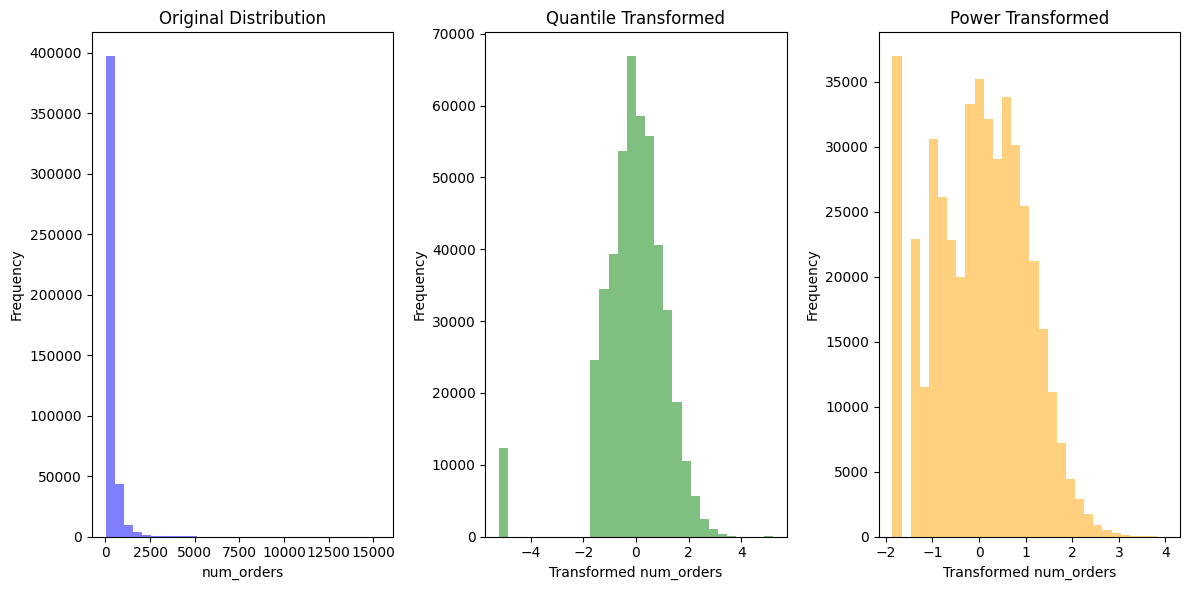

In [40]:
# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Original Distribution
plt.subplot(1, 3, 1)
plt.hist(train['num_orders'], bins=30, color='blue', alpha=0.5)
plt.title('Original Distribution')
plt.xlabel('num_orders')
plt.ylabel('Frequency')

# Quantile Transformed Distribution
plt.subplot(1, 3, 2)
plt.hist(train['num_orders_quantile'], bins=30, color='green', alpha=0.5)
plt.title('Quantile Transformed')
plt.xlabel('Transformed num_orders')
plt.ylabel('Frequency')

# Power Transformed Distribution
plt.subplot(1, 3, 3)
plt.hist(train['num_orders_power'], bins=30, color='orange', alpha=0.5)
plt.title('Power Transformed')
plt.xlabel('Transformed num_orders')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

It is evident that the quantile transformation reduced skewness more than the power transformation in our case.

The purpose of these transformations is to make the distribution of the data more symmetric and closer to a normal distribution.

Since the data already resembles a normal distribution after transformation, standardization (scaling to mean 0 and standard deviation 1) is a better option than normalization.

So after using our quartile transformer, we will use standard scaler.

In [41]:
# Drop these columns permanently
train.drop(['id', 'num_orders_quantile', 'num_orders_power'], axis=1, inplace=True)

## Features Encoding & scaling

In [42]:
train.head(2)

,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,ewma_base_price,ewma_discount,city_code,region_code,center_type,op_area,category,cuisine,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,meal_count_region_code,city_code_highest_price,city_code_lowest_price,city_code_avg_price,region_code_highest_price,region_code_lowest_price,region_code_avg_price,base_price_max,base_price_mean,base_price_min,center_cat_price_rank,center_price_rank,center_week_price_rank,meal_city_price_rank,meal_price_max,meal_price_mean,meal_price_min,meal_price_rank,meal_region_price_rank,meal_week_price_rank
0,1,55,1885,152.29,0,0,177,15.46,290.865718,29.895230,647,56,TYPE_C,2.0,Beverages,Thai,419380.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095,179.51,129.510377,88.27,391.5,396.5,3.0,266.5,179.51,129.510377,88.27,10658.0,3968.5,73.0
1,2,55,1885,152.29,0,0,323,16.46,311.990559,9.229357,647,56,TYPE_C,2.0,Beverages,Thai,419380.5,127890,118216,5146,11833,191227,728.53,113.49,351.409197,767.33,55.35,352.517095,179.51,129.510377,88.27,391.5,396.5,3.0,266.5,179.51,129.510377,88.27,10658.0,3968.5,73.5


In [43]:
train_week = train[['week']]

In [44]:
categoric_columns = ['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine']
columns = list(train.columns)
numeric_columns = [i for i in columns if i not in categoric_columns]

In [45]:
numeric_columns.remove('num_orders')
print(numeric_columns)

['week', 'base_price', 'discount', 'ewma_base_price', 'ewma_discount', 'meal_base_price_rank', 'meal_count_category', 'meal_count_cuisine', 'meal_count_center_id', 'meal_count_city_code', 'meal_count_region_code', 'city_code_highest_price', 'city_code_lowest_price', 'city_code_avg_price', 'region_code_highest_price', 'region_code_lowest_price', 'region_code_avg_price', 'base_price_max', 'base_price_mean', 'base_price_min', 'center_cat_price_rank', 'center_price_rank', 'center_week_price_rank', 'meal_city_price_rank', 'meal_price_max', 'meal_price_mean', 'meal_price_min', 'meal_price_rank', 'meal_region_price_rank', 'meal_week_price_rank']


In [46]:
encoder = BinaryEncoder(drop_invariant=False, return_df=True,)
encoder.fit(train[categoric_columns])

# Initialize LabelEncoder
# encoder = LabelEncoder()

BinaryEncoder(cols=['center_type', 'category', 'cuisine'],
              mapping=[{'col': 'center_type',
                        'mapping':     center_type_0  center_type_1
 1              0              1
 2              1              0
 3              1              1
-1              0              0
-2              0              0},
                       {'col': 'category',
                        'mapping':      category_0  category_1  category_2  category_3
 1            0           0           0           1
 2            0           0           1           0
 3            0           0           1           1
 4            0           1           0           0
 5            0           1           0           1
 6            0           1           1           0
 7            0           1           1           1
 8            1           0           0           0
 9            1           0           0           1
 10           1           0           1           0
 11           1           0           1           1
 12           1           1           0           0
 13           1           1           0           1
 14           1           1           1           0
-1            0           0           0           0
-2            0           0           0           0},
                       {'col': 'cuisine',
                        'mapping':     cuisine_0  cuisine_1  cuisine_2
 1          0          0          1
 2          0          1          0
 3          0          1          1
 4          1          0          0
-1          0          0          0
-2          0          0          0}])

In [47]:
# loop over each numerical column and test for normality
cols = 0
for col in train[numeric_columns]:
    stat, p = stats.normaltest(train[col])
    # print('Statistics=%.5f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'looks Gaussian (fail to reject H0) for this column: {col}')
    else:
        print(f'does not look Gaussian (reject H0) for this column: {col}')
        cols += 1
print('number of non-gaussian cols or cols that lack a normal distribution is:', cols, 'total cols:', len(numeric_columns))

does not look Gaussian (reject H0) for this column: week
does not look Gaussian (reject H0) for this column: base_price
does not look Gaussian (reject H0) for this column: discount
does not look Gaussian (reject H0) for this column: ewma_base_price
does not look Gaussian (reject H0) for this column: ewma_discount
does not look Gaussian (reject H0) for this column: meal_base_price_rank
does not look Gaussian (reject H0) for this column: meal_count_category
does not look Gaussian (reject H0) for this column: meal_count_cuisine
does not look Gaussian (reject H0) for this column: meal_count_center_id
does not look Gaussian (reject H0) for this column: meal_count_city_code
does not look Gaussian (reject H0) for this column: meal_count_region_code
does not look Gaussian (reject H0) for this column: city_code_highest_price
does not look Gaussian (reject H0) for this column: city_code_lowest_price
does not look Gaussian (reject H0) for this column: city_code_avg_price
does not look Gaussian (r

In [48]:
scaler = StandardScaler()
scaler.set_output(transform="pandas")
train_num_quantile = quantile_transformer.fit_transform(train[numeric_columns])
scaler.fit(train_num_quantile)

StandardScaler()

If the data didn't have a normal or Gaussian distribution and standardization (using StandardScaler) wasn't appropriate, an alternative method for normalization could be min-max scaling:

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

X_normalized = min_max_scaler.fit_transform(X)

In [49]:
encoded_cat = encoder.transform(train[categoric_columns])

scaled_num = scaler.transform(train[numeric_columns])
# encoded_cat = train[categoric_columns].apply(encoder.fit_transform)

train = pd.concat([scaled_num, encoded_cat, train.num_orders], axis=1)

In [50]:
train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,center_id,meal_id,emailer_for_promotion,homepage_featured,city_code,region_code,center_type_0,center_type_1,op_area,category_0,category_1,category_2,category_3,cuisine_0,cuisine_1,cuisine_2,num_orders
0,0.889013,151.212570,15.959043,292.812684,29.907545,418803.994988,46874.441641,32318.424146,4255.574157,5969.849062,64050.139752,241.187725,83.000904,290.270033,255.784123,19.121601,217.404885,113.193305,94.575695,69.727234,387.288304,396.971805,2.539757,259.968794,113.864901,94.673826,69.908082,10522.209972,3893.949312,66.159550,55,1885,0,0,647,56,0,1,2.0,0,0,0,1,0,0,1,177
1,1.780649,151.212570,16.992708,314.079103,9.227559,418803.994988,46874.441641,32318.424146,4255.574157,5969.849062,64050.139752,241.187725,83.000904,290.270033,255.784123,19.121601,217.404885,113.193305,94.575695,69.727234,387.288304,396.971805,2.539757,259.968794,113.864901,94.673826,69.908082,10522.209972,3893.949312,66.612462,55,1885,0,0,647,56,0,1,2.0,0,0,0,1,0,0,1,323
2,2.672284,132.974013,1.012255,296.414896,1.781545,438037.518948,46874.441641,32318.424146,4255.574157,5969.849062,64050.139752,241.187725,83.000904,290.270033,255.784123,19.121601,217.404885,113.193305,94.575695,69.727234,33.138434,36.534655,1.708474,17.566207,113.864901,94.673826,69.908082,6005.990556,290.942494,46.684319,55,1885,0,0,647,56,0,1,2.0,0,0,0,1,0,0,1,96
3,3.563919,133.907287,-1.055074,305.745784,0.115618,437813.327560,46874.441641,32318.424146,4255.574157,5969.849062,64050.139752,241.187725,83.000904,290.270033,255.784123,19.121601,217.404885,113.193305,94.575695,69.727234,39.073907,42.541941,2.124115,21.468059,113.864901,94.673826,69.908082,6068.187916,332.153356,49.401793,55,1885,0,0,647,56,0,1,2.0,0,0,0,1,0,0,1,163
4,4.455555,146.456844,1.012255,311.852867,1.048363,426494.408696,46874.441641,32318.424146,4255.574157,5969.849062,64050.139752,241.187725,83.000904,290.270033,255.784123,19.121601,217.404885,113.193305,94.575695,69.727234,271.546587,279.829731,2.539757,196.075959,113.864901,94.673826,69.908082,9263.453877,2896.057718,66.612462,55,1885,0,0,647,56,0,1,2.0,0,0,0,1,0,0,1,215


In [51]:
train['week_unscaled'] = train_week
# Split the dataset into training (weeks 1-135) and evaluation (weeks 136-145) sets
trainn = train[train['week_unscaled'] <= 135]
evall = train[train['week_unscaled'] > 135]

# Display the shapes of the training and evaluation sets
print("Training set shape:", trainn.shape)
print("Evaluation set shape:", evall.shape)

trainn.drop('week_unscaled', axis=1, inplace=True)
evall.drop('week_unscaled', axis=1, inplace=True)

Training set shape: (423726, 48)
Evaluation set shape: (32821, 48)


In [52]:
# Split data into parts
X_train = trainn.drop(['num_orders'], axis = 1)
X_test = evall.drop(['num_orders'], axis = 1)
y_train = trainn['num_orders']
y_test = evall['num_orders']

# Machine Learning Modeling

# Traditional Machine Learning Models

### RandomForestRegressor

In [ ]:
# Initialize and fit the Random Forest Regressor
forest = RandomForestRegressor()
model_forest = forest.fit(X_train, y_train)

# Make predictions on X_test
forest_pred = model_forest.predict(X_test)

In [54]:
mse = mean_squared_error(y_test, forest_pred)
msle = mean_squared_log_error(y_test, forest_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Append the results to the DataFrame
results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,17055.880063,0.294784,130.6,0.54294


### Gradient Boosting Machine

In [55]:
# Initialize and fit the Gradient Boosting model
gbr = GradientBoostingRegressor()
model_gbr = gbr.fit(X_train, y_train)

# Make predictions on X_test
gbr_pred = model_gbr.predict(X_test)

In [56]:
gbr_pred = np.abs(gbr_pred)

In [57]:
# Append the results to the DataFrame
mse = mean_squared_error(y_test, gbr_pred)
msle = mean_squared_log_error(y_test, gbr_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['Gradient Boosting', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,17055.880063,0.294784,130.60,0.54294
1,Gradient Boosting,22116.548290,0.559103,148.72,0.74773


### Light GBM

In [58]:
# Initialize and fit the LightGBM Regressor
lgbm = lgb.LGBMRegressor()
model_lgbm = lgbm.fit(X_train, y_train)

# Make predictions on X_test
lgbm_pred = np.abs(model_lgbm.predict(X_test))

# Compute performance metrics
mse = mean_squared_error(y_test, lgbm_pred)
msle = mean_squared_log_error(y_test, lgbm_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Create a DataFrame for the model results
model_results = pd.DataFrame([['LightGBM', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

# Concatenate the new results to the existing results DataFrame
results = pd.concat([results, model_results], ignore_index=True)
results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3707
[LightGBM] [Info] Number of data points in the train set: 423726, number of used features: 46
[LightGBM] [Info] Start training from score 264.493814


,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,17055.880063,0.294784,130.60,0.54294
1,Gradient Boosting,22116.548290,0.559103,148.72,0.74773
2,LightGBM,16755.829331,0.402008,129.44,0.63404


### XGBoost

In [59]:
# Initialize and fit the XGBoost model
xgboost = xgb.XGBRegressor()
model_xgboost = xgboost.fit(X_train, y_train)

# Make predictions on X_test
xgboost_pred = np.abs(model_xgboost.predict(X_test))

# Append the results to the DataFrame
mse = mean_squared_error(y_test, xgboost_pred)
msle = mean_squared_log_error(y_test, xgboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,17055.880063,0.294784,130.60,0.54294
1,Gradient Boosting,22116.548290,0.559103,148.72,0.74773
2,LightGBM,16755.829331,0.402008,129.44,0.63404
3,XGBoost,20688.158009,0.542822,143.83,0.73676


### CatBoost Regressor

In [60]:
# Initialize and fit the CatBoost Regressor
catboost = cb.CatBoostRegressor(silent=True)
model_catboost = catboost.fit(X_train, y_train)

# Make predictions on X_test
catboost_pred = np.abs(model_catboost.predict(X_test))

# Compute performance metrics
mse = mean_squared_error(y_test, catboost_pred)
msle = mean_squared_log_error(y_test, catboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Create a DataFrame for the model results
model_results = pd.DataFrame([['CatBoost', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

# Concatenate the new results to the existing results DataFrame
results = pd.concat([results, model_results], ignore_index=True)
results

,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,17055.880063,0.294784,130.60,0.54294
1,Gradient Boosting,22116.548290,0.559103,148.72,0.74773
2,LightGBM,16755.829331,0.402008,129.44,0.63404
3,XGBoost,20688.158009,0.542822,143.83,0.73676
4,CatBoost,19580.179220,0.510219,139.93,0.71430


RMSLE value, which
represents the average ratio of the predicted value to the
actual value, is 0.0084. These results indicate that the model (CatBoost)
is capable of making accurate predictions.

## Hyperparameter Tuning

The space in my computer could not handle this gridsearch, but feel free to try it on your own computer.

I also tried it on google colab but it took too long to fit the grid search. Google colab will disconnect the runtime if there is inactivity for a while, hence I was unable to complete the grid search.

Here are the specs of the computer the researchers used:

The hardware included a 12 GB NVIDIA GeForce RTX 3060 GPU and a CPU with 64 GB of memory

### RandomForestRegressor

In [61]:
# # Define the parameter grid
# param_grid = {
#     'max_depth': [8, 9, 10],
#     'max_features': ['sqrt'],
#     'n_estimators': [100, 150, 200],
#     'min_samples_leaf': [2, 3, 4]
# }

# # Initialize the Random Forest Regressor
# forest = RandomForestRegressor()

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='neg_mean_squared_log_error', cv=5)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best RMSLE score
# best_params = grid_search.best_params_
# best_rmsle = np.sqrt(-grid_search.best_score_)

# # Print the best parameters and best RMSLE score
# print("Best Parameters:", best_params)
# print("Best RMSLE Score:", best_rmsle)


### Gradient Boosting Machine

In [62]:
# # Define the parameter grid
# param_grid = {
#     'max_depth': [8, 9, 10],
#     'n_estimators': [80, 100, 120],
#     'min_samples_split': [4, 5, 6],
#     'loss': ['squared_error']
# }

# # Initialize the Gradient Boosting Regressor
# gbr = GradientBoostingRegressor()

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, scoring='neg_mean_squared_log_error', cv=5)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)


In [63]:
# # Get the best parameters and best RMSLE score
# best_params = grid_search.best_params_
# best_rmsle = np.sqrt(-grid_search.best_score_)

# # Print the best parameters and best RMSLE score
# print("Best Parameters:", best_params)
# print("Best RMSLE Score:", best_rmsle)

### Light GBM

In [64]:
# # Define the parameter grid
# param_grid = {
#     'max_depth': [7, 8, 9],
#     'learning_rate': [0.11, 0.13, 0.15],
#     'n_estimators': [130, 150, 170],
#     'reg_lambda': [2, 3, 4]
# }

# # Initialize the LightGBM Regressor
# lgbm = lgb.LGBMRegressor()

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='neg_mean_squared_log_error', cv=5)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best RMSLE score
# best_params = grid_search.best_params_
# best_rmsle = np.sqrt(-grid_search.best_score_)

# # Print the best parameters and best RMSLE score
# print("Best Parameters:", best_params)
# print("Best RMSLE Score:", best_rmsle)


### XGBoost

In [65]:
# # Define the parameter grid for XGBoost Regressor
# param_grid_xgboost = {
#     'max_depth': [8, 9, 10],
#     'n_estimators': [90, 100, 110],
#     'learning_rate': [0.08, 0.1, 0.12],
#     'tree_method': ['exact']
# }

# # Initialize the XGBoost Regressor
# xgboost = xgb.XGBRegressor()

# # Initialize GridSearchCV for XGBoost Regressor
# grid_search_xgboost = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgboost, scoring='neg_mean_squared_log_error', cv=5)

# # Fit the grid search to the data
# grid_search_xgboost.fit(X_train, y_train)

# # Get the best parameters and best RMSLE score for XGBoost
# best_params_xgboost = grid_search_xgboost.best_params_
# best_rmsle_xgboost = np.sqrt(-grid_search_xgboost.best_score_)

# # Print the best parameters and best RMSLE score for XGBoost
# print("XGBoost Best Parameters:", best_params_xgboost)
# print("XGBoost Best RMSLE Score:", best_rmsle_xgboost)


### CatBoost Regressor

In [66]:
# # Define the parameter grid for CatBoost Regressor
# param_grid_catboost = {
#     'iterations': [1800, 2000, 2200],
#     'learning_rate': [0.008, 0.01, 0.012],
#     'max_depth': [8, 9, 10],
#     'l2_leaf_reg': [6, 8, 10]
# }

# # Initialize the CatBoost Regressor
# catboost = cb.CatBoostRegressor(loss_function='RMSE', silent=True)

# # Initialize GridSearchCV for CatBoost Regressor
# grid_search_catboost = GridSearchCV(estimator=catboost, param_grid=param_grid_catboost, scoring='neg_mean_squared_log_error', cv=5)

# # Fit the grid search to the data
# grid_search_catboost.fit(X_train, y_train)

In [67]:
# # Get the best parameters and best RMSLE score for CatBoost
# best_params_catboost = grid_search_catboost.best_params_
# best_rmsle_catboost = np.sqrt(-grid_search_catboost.best_score_)

# # Print the best parameters and best RMSLE score for CatBoost
# print("CatBoost Best Parameters:", best_params_catboost)
# print("CatBoost Best RMSLE Score:", best_rmsle_catboost)

I'll just directly fit on the best hyperparameters specified in the research paper.

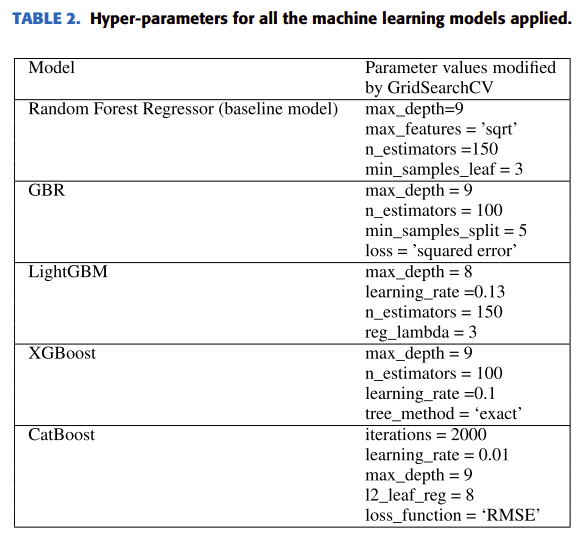

#### training with hyperparamaters

In [68]:
# Initialize and fit the Random Forest Regressor
forest = RandomForestRegressor(
    max_depth=9,
    max_features='sqrt',
    n_estimators=150,
    min_samples_leaf=3
)
model_forest = forest.fit(X_train, y_train)

# Initialize and fit the Gradient Boosting model
gbr = GradientBoostingRegressor(
    max_depth=9,
    n_estimators=100,
    min_samples_split=5,
    loss='squared_error'
)
model_gbr = gbr.fit(X_train, y_train)

# Initialize and fit the LightGBM Regressor
lgbm = lgb.LGBMRegressor(
    max_depth=8,
    learning_rate=0.13,
    n_estimators=150,
    reg_lambda=3
)
model_lgbm = lgbm.fit(X_train, y_train)

# Initialize and fit the XGBoost model
xgboost = xgb.XGBRegressor(
    max_depth=9,
    n_estimators=100,
    learning_rate=0.1,
    tree_method='exact'
)
model_xgboost = xgboost.fit(X_train, y_train)

# Initialize and fit the CatBoost Regressor
catboost = cb.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.01,
    max_depth=9,
    l2_leaf_reg=8,
    loss_function='RMSE',
    silent=True
)
model_catboost = catboost.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3707
[LightGBM] [Info] Number of data points in the train set: 423726, number of used features: 46
[LightGBM] [Info] Start training from score 264.493814


#### scoring

In [69]:
forest_pred = model_forest.predict(X_test)
mse = mean_squared_error(y_test, forest_pred)
msle = mean_squared_log_error(y_test, forest_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Append the results to the DataFrame
results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

gbr_pred = model_gbr.predict(X_test)
gbr_pred = np.abs(gbr_pred)
# Append the results to the DataFrame
mse = mean_squared_error(y_test, gbr_pred)
msle = mean_squared_log_error(y_test, gbr_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['Gradient Boosting', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)

lgbm_pred = np.abs(model_lgbm.predict(X_test))

# Compute performance metrics
mse = mean_squared_error(y_test, lgbm_pred)
msle = mean_squared_log_error(y_test, lgbm_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Create a DataFrame for the model results
model_results = pd.DataFrame([['LightGBM', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

# Concatenate the new results to the existing results DataFrame
results = pd.concat([results, model_results], ignore_index=True)

xgboost_pred = np.abs(model_xgboost.predict(X_test))

# Append the results to the DataFrame
mse = mean_squared_error(y_test, xgboost_pred)
msle = mean_squared_log_error(y_test, xgboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = pd.concat([results, model_results], ignore_index=True)

catboost_pred = np.abs(model_catboost.predict(X_test))

# Compute performance metrics
mse = mean_squared_error(y_test, catboost_pred)
msle = mean_squared_log_error(y_test, catboost_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

# Create a DataFrame for the model results
model_results = pd.DataFrame([['CatBoost', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

# Concatenate the new results to the existing results DataFrame
results = pd.concat([results, model_results], ignore_index=True)
results

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,Model,MSE,MSLE,RMSE,RMSLE
0,Random Forest,20731.490288,0.513270,143.98,0.71643
1,Gradient Boosting,17693.266330,0.354476,133.02,0.59538
2,LightGBM,15509.348210,0.389397,124.54,0.62402
3,XGBoost,15111.962942,0.340236,122.93,0.58330
4,CatBoost,15595.766995,0.365037,124.88,0.60418


# Deep Learning Models

### LSTM

In [70]:
# Create sequences for LSTM input
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

# Reshape y_train_seq and y_test_seq to be 2D arrays
y_train_seq = y_train_seq.reshape(-1, 1)
y_test_seq = y_test_seq.reshape(-1, 1)

# Check the shapes
print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

(423716, 10, 46) (423716, 1)
(32811, 10, 46) (32811, 1)


In [71]:
# Now proceed to create and train the LSTM model

# Define the LSTM model based on the provided architecture
def create_lstm_model(input_shape):
    model = Sequential()

    # LSTM layer 1
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(ReLU())
    model.add(Dropout(0.25))

    # LSTM layer 2
    model.add(LSTM(32, return_sequences=True))
    model.add(ReLU())
    model.add(Dropout(0.25))

    # LSTM layer 3
    model.add(LSTM(16))
    model.add(ReLU())
    model.add(Dropout(0.25))

    # Dense layer
    model.add(Dense(1))

    return model

# Create and compile the LSTM model
input_shape = (time_steps, X_train_seq.shape[2])
model = create_lstm_model(input_shape)
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=1, batch_size=16, shuffle=False, validation_data=(X_test_seq, y_test_seq))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            28416     
                                                                 
 re_lu (ReLU)                (None, 10, 64)            0         
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 re_lu_1 (ReLU)              (None, 10, 32)            0         
                                                                 
 dropout_1 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3

In [72]:
# Make predictions using the trained LSTM model
lstm_pred = model.predict(X_test_seq)

# Clip negative values to 0
lstm_pred = np.clip(lstm_pred, 0, None)

# Compute RMSLE
rmsle_lstm = np.sqrt(mean_squared_log_error(y_test_seq, lstm_pred))

# Print the RMSLE for the LSTM model
print("RMSLE for LSTM model:", rmsle_lstm)

1026/1026 [==============================] - 4s 3ms/step
RMSLE for LSTM model: 1.1508730190548158


### Bi-LSTM

In [73]:
# Define the Bi-LSTM model
def create_bilstm_model(input_shape):
    model = Sequential()

    # Bi-LSTM layer 1
    model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.25, recurrent_activation='tanh'), input_shape=input_shape))

    # Bi-LSTM layer 2
    model.add(Bidirectional(LSTM(16, return_sequences=False, dropout=0.25, recurrent_activation='tanh')))

    # Dense layer
    model.add(Dense(1))

    return model

# Create and compile the Bi-LSTM model
input_shape = (time_steps, X_train_seq.shape[2])
model = create_bilstm_model(input_shape)
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=1, batch_size=16, shuffle=False, validation_data=(X_test_seq, y_test_seq))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 10, 64)            20224     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
26483/26483 [==============================] - 1802s 68ms/step - loss: 177029.2031 - val_loss: 104614.8984


In [74]:
# Make predictions using the trained Bi-LSTM model
bilstm_pred = model.predict(X_test_seq)

# Clip negative values to 0
bilstm_pred = np.clip(bilstm_pred, 0, None)

# Compute RMSLE
rmsle_bilstm = np.sqrt(mean_squared_log_error(y_test_seq, bilstm_pred))

# Print the RMSLE for the Bi-LSTM model
print("RMSLE for Bi-LSTM model:", rmsle_bilstm)

1026/1026 [==============================] - 7s 7ms/step
RMSLE for Bi-LSTM model: 1.3570546027644597


In [75]:
import pickle

with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open("model_forest.pkl", "wb") as f:
    pickle.dump(model_forest, f)

with open("model_xgboost.pkl", "wb") as f:
    pickle.dump(model_xgboost, f)

with open("model_gbr.pkl", "wb") as f:
    pickle.dump(model_gbr, f)
